<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import spacy
import html.parser
from lxml import html

## 1) *Optional:* Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [2]:
# imports csv from assignment folder, replace with webscraped data if time allows
df0 = pd.read_csv('data/job_listings.csv', index_col=0)

## 2) Use Spacy to tokenize / clean the listings 

In [66]:
# setting up natural language processor and tokenizer
nlp = spacy.load('en_core_web_lg')
tokenizer = spacy.tokenizer.Tokenizer(nlp.vocab)

# creates stop words
STOPWORDS = nlp.Defaults.stop_words.union({' ', ''})

# # function to tokenize
# def tokenize(text):
#     doc = nlp(text)
#     return[token.lemma_ for token in doc if (token.is_stop != True) & (token.is_punct != True)]

In [67]:
# makes a copy of df
df = df0.copy()

# removes html elements with lxml
df['description'] = df['description'].apply(lambda x: html.fromstring(x).text_content())

# replaces new line charecters with space
df['description'] = df['description'].apply(lambda x: x.replace('\\n', ' '))

# removes punctuation with regex
df['description'] = df['description'].apply(lambda x: re.sub(r'[^a-zA-Z ]', '', x))

# removes the b at the start of every string
df['description'] = df['description'].apply(lambda x: x[1:])

# makes all words lowercase
df['description'] = df['description'].apply(lambda x: x.lower())

# # tokenize the data
# df['description'] = df['description'].apply(tokenizer)

# # removes stopwords
# df['description'] = df['description'].apply(lambda x: rm_stopwords(x))

# # takes lemmas of tokens
# df['description'] = df['description'].apply(lambda x: [token.lemma_ for token in x])

In [68]:
df.head()

,description,title
0,job requirements conceptual understanding in m...,Data scientist
1,job description as a data scientist you will...,Data Scientist I
2,as a data scientist you will be working on con...,Data Scientist - Entry Level
3,a monthcontractunder the general supervisio...,Data Scientist
4,location usa xexx multiple locations years of...,Data Scientist


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [69]:
vect = CountVectorizer(stop_words='english', min_df=0.02, max_df=0.90, lowercase=True)

vect.fit(df['description'])

dtm = vect.transform(df['description'])

dfWords = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

dfWords.head()

,ab,abilities,ability,able,academic,accelerate,accept,access,accessible,accommodation,...,year,years,yearsxexx,yes,york,youll,youre,youxexxll,youxexxre,youxexxve
0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [70]:
# creates a df of the most common words and then a df of the top 15

common_words = pd.DataFrame(dfWords.sum().sort_values(ascending=False))

common_words.reset_index(inplace=True)

common_words.columns=['word', 'count']

top15words = common_words.head(15)

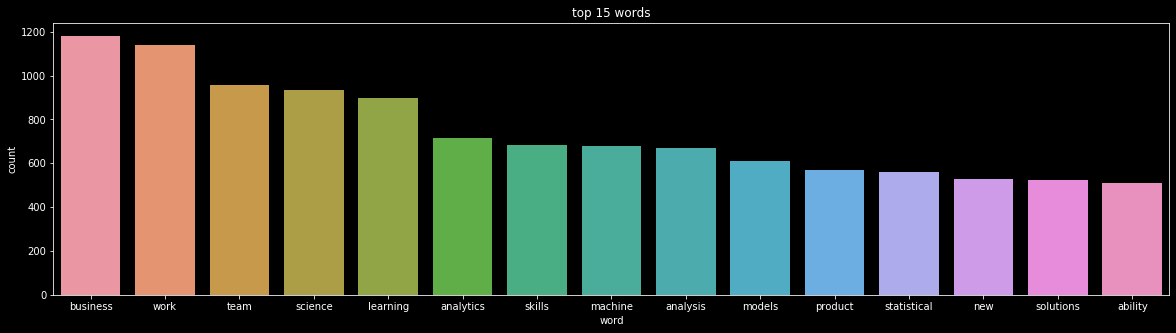

In [71]:
# plots the top 15 words
plt.style.use('dark_background')
plt.figure(figsize=(20, 5))
sns.barplot(x=top15words['word'], y=top15words['count']).set_title('top 15 words');

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [74]:
tfidf = TfidfVectorizer(stop_words='english', min_df = 0.2, max_df=0.99, ngram_range=(1,2), lowercase=True)

sparse_dtm = tfidf.fit_transform(df['description'])

DF = pd.DataFrame(sparse_dtm.todense(), columns=tfidf.get_feature_names())

In [75]:
DF.head()

,ability,able,advanced,age,algorithms,analyses,analysis,analytical,analytics,analyze,...,veteran,veteran status,visualization,way,work,working,world,written,years,years experience
0,0.295921,0.0,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.00000,0.112122,0.000000,0.000000,0.000000,0.0000,0.0
1,0.053355,0.0,0.000000,0.000000,0.00000,0.0,0.04663,0.061912,0.000000,0.0,...,0.000000,0.000000,0.0,0.08353,0.161726,0.105873,0.069546,0.075425,0.0000,0.0
2,0.112852,0.0,0.134864,0.000000,0.14384,0.0,0.00000,0.130952,0.111384,0.0,...,0.000000,0.000000,0.0,0.00000,0.000000,0.111967,0.000000,0.000000,0.0000,0.0
3,0.000000,0.0,0.000000,0.148078,0.00000,0.0,0.00000,0.000000,0.000000,0.0,...,0.139337,0.147494,0.0,0.00000,0.145667,0.000000,0.000000,0.000000,0.0000,0.0
4,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.225260,0.0,...,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.2145,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [78]:
# sets up nearest neighbor parameters
nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')

# fits nearest neighbor model to tfidf vector matrix
nn.fit(DF)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [80]:
# querys a arbitrary job listing
nn.kneighbors([DF.iloc[12]])

(array([[0.        , 0.        , 0.90846087, 0.97782601, 0.98150786]]),
 array([[ 28,  12, 199, 410,  34]]))

In [85]:
# the same job posting was posted more than once since this returns true
# this explains the 0 value from before
df['description'][28] == df['description'][12] 

True

In [98]:
my_job_description = ['''
    In search of a entry level data scientist to join a team doing data science! \n
    The ideal candidate will be proficient in python as well as the following python libraries: \m
    pandas, numpy, seaborn, matplotlib, sklearn, and spacy
''']

my_job_transformed = tfidf.transform(my_job_description)

In [99]:
# looks for similar job postings

nn.kneighbors(my_job_transformed.todense())

(array([[1.10458443, 1.14209807, 1.14244028, 1.16469432, 1.17165091]]),
 array([[291, 421, 178, 401, 210]]))

In [101]:
# looks at most similar result

df['description'][291]

'our growing data science team is central to our global strategy their work enables our clients to quickly create and deploy solutions that drive innovation optimise operations offer insight and drive transformation ultimately the team are responsible for enabling our clientxexxs competitiveness by accelerating roi from any data science initiative with products that transform data into insight  operating across sectors and with a high degree independence our data scientists have helped improve performance for f teams built solutions for reducing fraud in financial trading and initiated changes in californian traffic laws we are looking for a senior data scientist to join our team you are seeking an opportunity to deliver thought leadership to challenge and develop both your knowledge as well as our clientxexxs data science capabilities you will join a team of highly collaborative individuals as a senior team member and play a key role in developing our capability and establishing tibco

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 